Author: Chris Suberlak (@suberlak)

Software Versions:

* ts_wep: **v2.5.4**
* lsst_distrib: **w_2022_32**

## Introduction

The Active Optics System wavefront estimation pipeline is at the core of the system helping to maintain alignment of the Large Synoptic Survey Telescope  (LSST) mirrors. The gravity and thermal gradients cause corrections that are included in the static Look-Up Table. The AOS system uses defocal images to estimate the wavefront curvature, and correct the mirror shape, adjusting the 50 degrees of freedom distributed amongst bending modes of M1M3, M2, and rigid body positions of M2 and the camera. Due to annular aperture, the out-of-focus point sources appear as donuts. The AOS system utilizes four corner wavefront sensors, each divided in two parts - one extrafocal, and the other intrafocal. Thus each corner sensor provides a simultanous image of defocal sources on both sides of focus. These donuts are paired up, and each pair of donuts provides an estimate of  the wavefront shape in terms of the Zernike polynomial coefficients. An entire process is described in eg. [Xin+2015](https://opg.optica.org/ao/abstract.cfm?uri=ao-54-30-9045). This document serves as an in-depth overview of each step taken inside the algorithm to to get from images to Zernikes. 

To test and improve the performance of the AOS loop, the telescope operation is simulated with `ts_phosim` (`CloseLoopTask`). Resulting  defocal images are  analyzed with `ts_wep` (Wavefront Estimation Pipeline), and corrections are applied to the corresponding telescope subsystems with `ts_ofc` (Optical Feedback Control). 
 
The curvature sensing algorithm is part of the `ts_wep` package. Given a pair of defocal images, `ts_wep` detects donuts, and creates postage stamp image cutouts around each donut. The immediate output of `ts_wep` per donut pair is a raw estimate of the wavefront error called [outputZernikesRaw](https://github.com/lsst-ts/ts_wep/blob/3825b283de5664cdb88c3824298e096c2bc6fbf5/python/lsst/ts/wep/task/EstimateZernikesBase.py#L511). This information is combined  (per sensor) to make  [outputZernikesAvg](https://github.com/lsst-ts/ts_phosim/blob/2a06807d495eb21e38aac196b0c88d6842de0f72/python/lsst/ts/phosim/CloseLoopTask.py#L660).  `CloseLoopTask` passes the sensor-averaged  wavefront error estimate to `ts_ofc`. The corrections are then applied to the simulated mirror system (M1M2, M3). With improved mirror shape, another exposure is simulated. This  process is repeated several times. The simulation of several subsequent exposures has converged if  the image quality metrics (such as Full Width Half-Maximum, FWHM or Point Source Sensitivity Normalized, PSSN) improve from the initial perturbations, and remain stable. 

Below we we explore parts of `Algorithm.py`, that lead to the calculation of `outputZernikesRaw`. Steps inside the Algorithm follow a cycle of iterative improvements to the wavefront estimation, but the term iteration pertains there to a different process than in the `CloseLoopTask`. Indeed, per single iteration of `CloseLoopTask`, there are 14 (usually) iterations of the outer loop of the `Algorithm` to arrive at the wavefront estimate. In this note we use a simulation of corner sensor images. An accompanying [presentation](https://docs.google.com/presentation/d/1VIxGTr4gPJ3NtSV21Tp3ROIvEmKjjHnQ6J551yaF-EY/edit?usp=sharing) is also available.

## Imports

In [1]:
import yaml
import os
import numpy as np
from scipy.ndimage import rotate

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib as mpl
from matplotlib import rcParams

from lsst.ts.wep.cwfs.Instrument import Instrument
from lsst.ts.wep.cwfs.Algorithm import Algorithm
from lsst.ts.wep.cwfs.CompensableImage import CompensableImage
from lsst.ts.wep.Utility import (
    getConfigDir,
    DonutTemplateType,
    DefocalType,
    CamType,
    getCamType,
    getDefocalDisInMm,
    CentroidFindType
)
from lsst.ts.wep.ParamReader import ParamReader
from lsst.ts.wep.cwfs.Tool import (
    padArray,
    extractArray,
    ZernikeAnnularGrad,
    ZernikeAnnularJacobian,
)

from lsst.ts.wep.task.DonutStamps import DonutStamp, DonutStamps
from lsst.ts.wep.task.EstimateZernikesCwfsTask import (
    EstimateZernikesCwfsTask,
    EstimateZernikesCwfsTaskConfig,
)

from lsst.daf import butler as dafButler
import lsst.afw.cameraGeom as cameraGeom
from lsst.afw.cameraGeom import FOCAL_PLANE, PIXELS, FIELD_ANGLE
from lsst.geom import Point2D

from astropy.visualization import ZScaleInterval

from scipy.ndimage import generate_binary_structure, iterate_structure
from scipy.ndimage import binary_dilation, binary_erosion
from scipy.interpolate import RectBivariateSpline
from scipy.signal import correlate



# Note: algorithm_functions are a collection of 
# python scripts that make this tech note 
# more readable; to execute them in the notebook
# it is assumed that they have been imported by eg. 
# cloning the github repo containing 
# this notebook, and adding that path_to_notebook with
# import sys 
# sys.path.append(path_to_notebook)
# if the notebook is run from the same directory
# this step is not needed 
import algoritm_functions as func

INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

## Preparing input data

We read in the images as well as donut catalogs by quering for the  data products of a previous run of `CloseLoopTask`.

In [3]:
mag = 15
repo_dir = f'/sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_{mag}/phosimData/'
instrument = 'LSSTCam'
collection = 'ts_phosim_9006000'
sensor='R04'
donutStampsExtra, extraFocalCatalog = func.get_butler_stamps(repo_dir,instrument=instrument, 
                                      iterN=0, detector=f"{sensor}_SW0",
                                      dataset_type = 'donutStampsExtra', 
                                      collection=collection)

donutStampsIntra, intraFocalCatalog = func.get_butler_stamps(repo_dir,instrument=instrument, 
                                      iterN=0, detector=f"{sensor}_SW1",
                                      dataset_type = 'donutStampsIntra', 
                                      collection=collection)

extraImage = func.get_butler_image(repo_dir,instrument=instrument,
                              iterN=0, detector=f"{sensor}_SW0",
                              collection=collection)

Here we follow the steps of [`EstimateZernikesBase.estimateZernikes`](https://github.com/lsst-ts/ts_wep/blob/3ae4b2853cbc1af067d75ad3e60096a2beb7811d/python/lsst/ts/wep/task/EstimateZernikesBase.py#L488): configuring `Algorithm` and `Instrument` classes, as well as initializing the `CompensableImage` class needed used in the algorithm:

In [4]:
# get the pixel scale from exposure to convert from pixels to arcsec to degrees
pixelScale = extraImage.getWcs().getPixelScale().asArcseconds()
configDir = getConfigDir()
instDir = os.path.join(configDir, "cwfs", "instData")
algoDir = os.path.join(configDir, "cwfs", "algo")

# inside wfEsti = WfEstimator(instDir, algoDir)

# this is part of the init
inst = Instrument()
algo = Algorithm(algoDir)

# inside estimateZernikes()
instName='lsst'
camType = getCamType(instName)
defocalDisInMm = getDefocalDisInMm(instName)

# inside wfEsti.config
opticalModel = 'offAxis'
sizeInPix = 160  # aka donutStamps
inst.configFromFile(sizeInPix, camType)
# choose the solver for the algorithm
solver = 'exp' # by default
debugLevel = 0 # 1 to 3
algo.config(solver, inst, debugLevel=debugLevel)

centroidFindType = CentroidFindType.RandomWalk
imgIntra = CompensableImage(centroidFindType=centroidFindType)
imgExtra = CompensableImage(centroidFindType=centroidFindType)

# select a donut pair in that corner
i=1
donutExtra = donutStampsExtra[i]
j=4
donutIntra = donutStampsIntra[j]

Show the two donut images

Text(0.5, 1.0, 'intra')

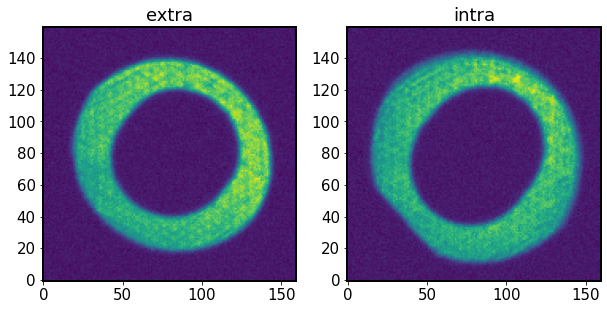

In [5]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(donutExtra.stamp_im.image.array, origin='lower')
ax[0].set_title('extra')
ax[1].imshow(donutIntra.stamp_im.image.array, origin='lower')
ax[1].set_title('intra')

In [6]:
# Inside EstimateZernikesBase
# Transpose field XY because CompensableImages below are transposed
# so this gets the correct mask orientation in Algorithm.py
fieldXYExtra = donutExtra.calcFieldXY()[::-1]
fieldXYIntra = donutIntra.calcFieldXY()[::-1]

# same camera for both donuts
camera = donutExtra.getCamera() 
detectorExtra = camera.get(donutExtra.detector_name)
detectorIntra = camera.get(donutIntra.detector_name)


# Rotate any sensors that are not lined up with the focal plane.
# Mostly just for the corner wavefront sensors. The negative sign
# creates the correct rotation based upon closed loop tests
# with R04 and R40 corner sensors.
eulerZExtra = -detectorExtra.getOrientation().getYaw().asDegrees()
eulerZIntra = -detectorIntra.getOrientation().getYaw().asDegrees()

# now inside  `wfEsti.setImg` method,
# which inherits from `CompensableImage`
imgExtra.setImg(fieldXYExtra,
                DefocalType.Extra,
                image=rotate(donutExtra.stamp_im.getImage().getArray(), eulerZExtra).T)

imgIntra.setImg(fieldXYIntra,
                DefocalType.Intra,
                image=rotate(donutIntra.stamp_im.getImage().getArray(), eulerZIntra).T)


# Algorithm: single iteration in detail

Now that all the data is setup as a `compensableImage` and both `Algorithm` and `Instrument` classes are initiated, we are able to make the direct call to the `runIt` method that takes two defocal images to perform the wavefront estimation: 
    
    tol = 1e-3 # explicitly set the tolerance level ( this is default )
    algo.runIt(imgIntra, imgExtra, opticalModel, tol=tol)

In [7]:
# rename to just like it is in Algorithm.py
I1 = imgIntra
I2 = imgExtra
model = opticalModel
tol = 1e-3 

Dig inside `Algorithm.py`. We call `runIt` method which contains multiple calls to `_singleItr`, which includes the `outer` and `inner` loops. From `Algorithm.runIt` [docstring](https://github.com/lsst-ts/ts_wep/blob/40a62fd336ee7d150afa5ae4c7392b7001c6cfaf/python/lsst/ts/wep/cwfs/Algorithm.py#L539):

> The inner loop is to solve the Poisson's equation. The outer loop is to compensate the intra- and extra-focal images to mitigate the calculation of wavefront  (e.g. S = -1/(delta Z) * (I1 - I2)/ (I1 + I2))."

The signature for `runIt` is :

    def runIt(self, I1, I2, model, tol=1e-3):
        
        # To have the iteration time initiated from global variable is to
        # distinguish the manually and automatically iteration processes.
        itr = self.currentItr
        while itr <= self.getNumOfOuterItr():
            stopItr = self._singleItr(I1, I2, model, tol)

            # Stop the iteration of outer loop if converged
            if stopItr:
                break

            itr += 1

The `getNumOfOuterItr()` method shows us the number of outer iterations to perform:

In [8]:
algo.getNumOfOuterItr()

14

This number is set in [`policy/algo/exp.yaml`](https://github.com/lsst-ts/ts_wep/blob/develop/policy/cwfs/algo/exp.yaml) file. The other possible settings become apparent upon inspection of the contents of the `yaml` file:

    # Algorithm parameters to solve the transport of intensity equation (TIE)

    # The way to solve the Poisson equation
    # fft: Fast Fourier transform method per Roddier & Roddier 1993
    # exp: Series expansion method per Guruyev & Nugent 1996
    poissonSolver: exp

    # Maximum number of Zernike polynomials supported
    numOfZernikes: 22

    # Obscuration ratio used in Zernike polynomials
    # 0: Standard filled
    # 1: Annular as defined by system in instParam.yaml
    # others (0 < x < 1): Use as the obscuration ratio
    obsOfZernikes: 1

    # Number of outer loop iteration when solving TIE
    numOfOuterItr: 14

    # Gain value used in the outer loop iteration
    feedbackGain: 0.6

    # Number of polynomial order supported in off-axis correction
    offAxisPolyOrder: 10

    # Method to compensate the wavefront by wavefront error
    # zer: Derivatives and Jacobians calculated from Zernike polynomials
    # opd: Derivitives and Jacobians calculated from wavefront map
    compensatorMode: zer

    # Compensate the image based on the Zk from the lower terms first according to
    # the sequence defined here
    # Sets compensated zernike order vs iteration
    compSequence: [4, 4, 6, 6, 13, 13, 13, 13, 22, 22, 22, 22, 22, 22]

    # Defines how far the computation mask extends beyond the pupil mask and, in
    # fft algorithm, it is also the width of Neuman boundary where the derivative
    # of the wavefront is set to zero
    boundaryThickness: 8


The `outer` loop uses the `compensated sequence` because in each iteration of the `outer` loop we fit Zernike polynomials up to a certain degree. Eg. in first outer loop we fit Zk1, Zk2, Zk3, Zk4 (i.e. Zk1-4), in the second outer loop Zk1-4, in the thire Zk1-6, etc. This is also stated in the following excerpt from Xin2015, Sec 2A:

> To decouple Zernike terms with the same azimuthal frequency, for example, between tip- tilt and astigmatisms, and defocus and spherical aberration, only a certain number of low-order Zernike terms are compensated at each outer iteration. After the algorithm has converged on low-order terms, higher-order terms are added to the compensated wavefront. The tests we show in Section 4 each include 14 outer iterations, with the highest Zernike index of 4, 4, 6, 6, 13, 13, 13, 13, 22, 22, 22, 22, 22, and 22, respectively.
<cite>Xin+2015</cite>

In [9]:
len(algo.getCompSequence())

14

We start from iteration 0:

In [10]:
itr = algo.currentItr
print(itr)

0


Then a `_singleItr` is  called, which contains

    def _singleItr(self, I1, I2, model, tol=1e-3):

In [11]:
# initially the compensable image has not been calculated 
type(I1.getImgInit())

NoneType

`model` stands for optical model (explained below). It can be `offAxis`, `onAxis`, `paraxial`. 

In [12]:
model

'offAxis'

In [13]:
# Use the zonal mode ("zer")
compMode = algo.getCompensatorMode()

# Define the gain of feedbackGain
feedbackGain = algo.getFeedbackGain()

We get the compensation mode ("zer") and feedback gain (0.6). From Xin2015 Sec.A: 
    
> Our compensation algorithm has an oversampling parameter, which enables subpixel resolution for the mapping between the pupil and image planes. We can choose to improve the compensation performance by increasing the subpixel sampling, but at a cost of computation time. Due to the fact that the compensation is based on geometrical ray-tracing, we always compensate on the original defocused images. A feedback gain less than unity is used to prevent large oscillation in the final wavefront estimation, i.e., upon each outer iteration only part of the residual is compensated. <cite>Xin+2015</cite>

If this is the first iteration, we calculate the mask for each image:

In [14]:
# Set the pre-condition
if algo.currentItr == 0:

    # Check this is the first time of running iteration or not
    if I1.getImgInit() is None or I2.getImgInit() is None:

        # Check the image dimension
        if I1.getImg().shape != I2.getImg().shape:
            print(
                "Error: The intra and extra image stamps need to be of same size."
            )
          

        # Calculate the pupil mask (binary matrix) and related
        # parameters
        boundaryT = algo.getBoundaryThickness()
        I1.makeMask(algo._inst, model, boundaryT, 1)
        I2.makeMask(algo._inst, model, boundaryT, 1)
        

Show the masks:

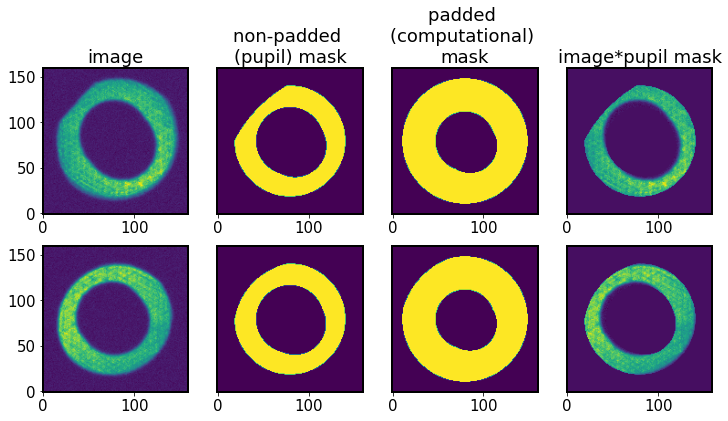

In [15]:
fig,ax = plt.subplots(2,4,figsize=(12,6))

# top row: intra img and mask 
for row, I, title in zip([0,1],
                         [I1,I2],
                         ['intra','extra']
                        ):
    ax[row,0].imshow(I.getImg(), origin='lower') # image 
    ax[row,1].imshow(I.getNonPaddedMask(), origin='lower') # pupil
    ax[row,2].imshow(I.getPaddedMask(), origin='lower') # comp
    ax[row,3].imshow(I.getImg()*I.getNonPaddedMask(), origin='lower')
    
row=0
ax[row,0].set_title('image')
ax[row,1].set_title('non-padded \n(pupil) mask')    
ax[row,2].set_title('padded \n(computational) \nmask')
ax[row,3].set_title('image*pupil mask')
for row in [0,1]:
    for col in [1,2,3]:
        ax[row,col].set(ylabel=None)
        ax[row,col].tick_params(left=False)
        ax[row,col].set(yticklabels=[]) 

The computational (padded) mask does not lose vignetting, but it is harder to notice in the example above because the original image is not strongly vignetted. Examples of more vignetted computational masks are below, showing two computational masks, using the default boundary thickness (padding) of 8 pixels. One is at the field distance `1.6` degrees, and the other at `2.3` degrees. The right-hand-side panel exhibits the effects of  vignetting in the upper-right corner.

In [16]:
import importlib as imp
imp.reload(func)

<module 'algoritm_functions' from '/sdf/data/rubin/user/scichris/WORK/AOS/algoritm_functions.py'>

Text(0.5, 1.0, 'cMask, boundaryT=7')

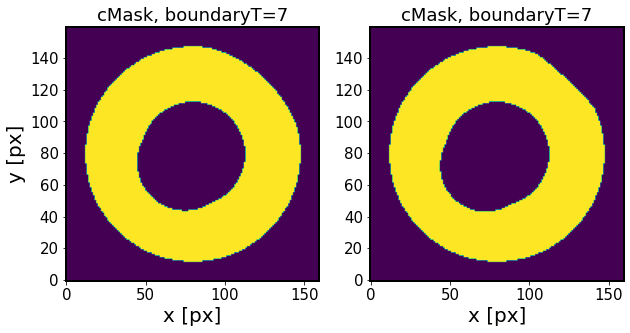

In [17]:
%matplotlib inline


comp1 = func.get_comp_image(boundaryT=7, optical_model="offAxis", 
                       maskScalingFactorLocal =1, field_xy = (1.1,1.2),
                        donut_stamp_size = 160, inst_name='lsst')

comp2 = func.get_comp_image(boundaryT=7, optical_model="offAxis", 
                       maskScalingFactorLocal =1, field_xy = (1.6,1.7),
                        donut_stamp_size = 160, inst_name='lsst')


fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(comp1.mask_comp, origin='lower')
ax[0].set_title('cMask, boundaryT=7')
for i in range(2): ax[i].set_xlabel('x [px]')
ax[0].set_ylabel('y [px]')
ax[1].imshow(comp2.mask_comp, origin='lower')
ax[1].set_title('cMask, boundaryT=7')

The subsequent call to 

      algo._makeMasterMask(I1, I2, algo.getPoissonSolverName())

creates a master mask, which is the overlap region:

    # Get the overlap region of mask for intra- and extra-focal images.
    # This is to avoid the anomalous signal due to difference in
    # vignetting.
    self.mask_comp = I1.getPaddedMask() * I2.getPaddedMask()
    self.mask_pupil = I1.getNonPaddedMask() * I2.getNonPaddedMask()
    
    
This is described in Xin2015 in Sec3D:


> The vignetting pattern still varies by field. To avoid anomalous signal due to the difference in vignetting from entering the wavefront estimation results, we mask off the intrafocal and extrafocal images using a common pupil mask, which is the logical AND of the pupil masks at the intrafocal and extrafocal field positions.
<cite>Xin+2015</cite>


In [18]:
algo._makeMasterMask(I1, I2, algo.getPoissonSolverName())

Show the new masks:

Text(-0.6, 0.45, 'comp')

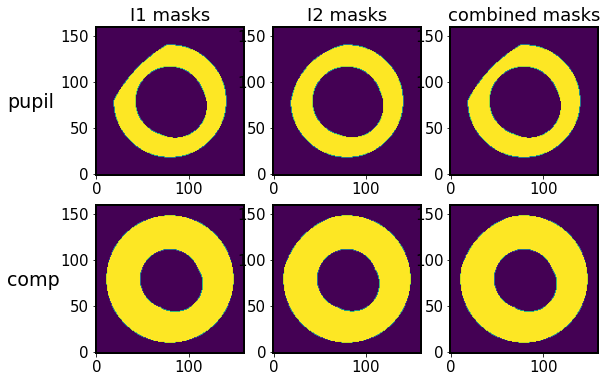

In [19]:
fig,ax = plt.subplots(2,3, figsize=(9,6))

row = 0
ax[row,0].imshow(I1.getNonPaddedMask(), origin='lower')
ax[row,1].imshow(I2.getNonPaddedMask(), origin='lower')
ax[row,2].imshow(algo.mask_pupil, origin='lower')
ax[row,0].set_title('I1 masks')
ax[row,1].set_title('I2 masks')
ax[row,2].set_title('combined masks')

row=1
ax[row,0].imshow(I1.getPaddedMask(), origin='lower')
ax[row,1].imshow(I2.getPaddedMask(), origin='lower')
ax[row,2].imshow(algo.mask_comp, origin='lower')



ax[0,0].text(-0.6,0.45, 'pupil', fontsize=19,transform=ax[0,0].transAxes)
ax[1,0].text(-0.6,0.45, 'comp', fontsize=19,transform=ax[1,0].transAxes)

Now we set the coefficients of off-axis correction for x, y-projection of intra- and extra-image. This is for the mapping of coordinate from the telescope aperture to defocal image plane. The model describes how the mask changes as a function of the off-axis distance, and is a linear interpolation of the ZEMAX model parameters. 

In [20]:
# Load the offAxis correction coefficients
if model == "offAxis":
    offAxisPolyOrder = algo.getOffAxisPolyOrder()
    I1.setOffAxisCorr(algo._inst, offAxisPolyOrder)
    I2.setOffAxisCorr(algo._inst, offAxisPolyOrder)


Then we **cocenter** the images. This means first finding the weighing center of the image binary (found by  default with  [CentroidRandomWalk](https://github.com/lsst-ts/ts_wep/blob/develop/python/lsst/ts/wep/cwfs/CentroidRandomWalk.py) via [scipy.ndimage.center_of_mass](https://github.com/lsst-ts/ts_wep/blob/40a62fd336ee7d150afa5ae4c7392b7001c6cfaf/python/lsst/ts/wep/cwfs/CentroidDefault.py#L76) and the effective weighing radius, as 

    radius = np.sqrt(np.sum(imgBinary) / np.pi)

Steps of the cocenter are:
* find the center of mass  of the image binary using `scipy.ndimage.center_of_mass`  (`x1`, `y1`)
* find the center of the image `xc`, `yc`   ( called in coCenter `stampCenterx1`, `stampCentery1`)
* find the radial shift given the `pixelSize`, defocal `offset` , reference distortion value in pixels (called `fov`), scale it by the distance to the center of FOV  `fieldDist/(fov/2)`, decompose radial shift into x,y components : `xShift`, `yShift`
* apply `xShift`, `yShift` to the stamp center coordinates, getting shifted x,y coordinates (`xcs = xc + xShift` )
* roll the image  by the difference between the original `x1`,`y1` and the `xcs`, `ycs` coordinates

Comparison of `cocenter`  and `recenter` (done later during image compensation):

| cocenter         | recenter     | 
|--------------|-----------|
| only done once, in [0th iteration](https://github.com/lsst-ts/ts_wep/blob/6a99e8e438dec9a1f67c659dd1eddee395276d72/python/lsst/ts/wep/cwfs/Algorithm.py#L706 ) | done at [each iteration](https://github.com/lsst-ts/ts_wep/blob/6a99e8e438dec9a1f67c659dd1eddee395276d72/python/lsst/ts/wep/cwfs/Algorithm.py#L748), part of image compensation      | 
| correct for the non-linear off-axis distortion using the ZEMAX-calculated distortion coefficient, that depends on the distance from the center of the field of view   | align the image with the interpolation template used to transform to the pupil plane  |


Show how the amount of radial shift applied at cocenter stage varies as a funtion of radial distance. This method is at the core of [`imageCoCenter`](https://github.com/lsst-ts/ts_wep/blob/3ae4b2853cbc1af067d75ad3e60096a2beb7811d/python/lsst/ts/wep/cwfs/CompensableImage.py#L273):

Text(0.5, 1.0, 'offset 1.5 mm, pixelSize 10.0 $\\mu m$')

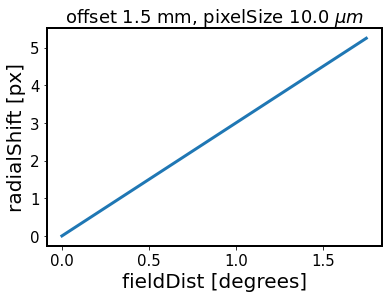

In [21]:
fov=3.5
offset = inst.defocalDisOffset # in meters
pixelSize = inst.pixelSize # in meters
radialShift = fov * (offset / 1e-3) * (10e-6 / pixelSize)

# define an array of possible field distances 
fieldDist = np.linspace(0,fov/2)
plt.plot(fieldDist, radialShift * (fieldDist / (fov / 2)), lw=3)
plt.xlabel('fieldDist [degrees]')
plt.ylabel('radialShift [px]')
plt.title(f'offset {offset*1e3} mm, pixelSize {pixelSize*1e6} '+r'$\mu m$')

In [22]:
# store images before co-centering
I1imgInit = I1.getImg()
I2imgInit = I2.getImg()

Show what `imageCoCenter` does inside `CompensableImage`:

In [23]:
import importlib as imp
imp.reload(func)
store = {'intra':{}, 'extra':{}}
store['intra'] = func.imageCoCenter_store(I1,algo._inst,fov=3.5, debugLevel=3,)
store['extra'] = func.imageCoCenter_store(I2,algo._inst,fov=3.5, debugLevel=3,)

imageCoCenter: (x, y) = (   81.47,   80.69)

imageCoCenter: (x, y) = (   78.84,   78.06)



We shift the image in the x and y direction given the 

    stampCenterx1 = stampCenterx1 + radialShift * cos(theta)
    stampCentery1 = stampCentery1 + radialShift * sin(theta)
    
using `np.roll` :
    
    np.roll(self.getImg(), int(np.round(stampCentery1 - y1)), axis=0)
    
We print the diagnostic below:

In [24]:
for defocal in ['intra', 'extra']:
    xc = store[defocal]['cocenter_centroid_x1']
    yc = store[defocal]['cocenter_centroid_y1']
    r =  store[defocal]['cocenter_fieldDist']
    dr = store[defocal]['cocenter_radialShift']
    dx = store[defocal]['cocenter_xShift']
    dy = store[defocal]['cocenter_yShift']
    print(f'\n {defocal}')
    print(f'x,y centroid = ({np.round(xc,3)},{np.round(yc,3)}) [px]')
    print(f'field distance r={np.round(r,3)} [deg]')
    print(f'radial shift = {np.round(dr,3)}[px]')
    print(f'x,y-shift ({np.round(dx,3)},{np.round(dy,3)})[px]')


 intra
x,y centroid = (81.466,80.69) [px]
field distance r=1.775 [deg]
radial shift = 5.324[px]
x,y-shift (-0.0,0.0)[px]

 extra
x,y centroid = (78.839,78.06) [px]
field distance r=1.65 [deg]
radial shift = 4.951[px]
x,y-shift (-3.609,3.389)[px]


Illustrate the effect of `imageCoCenter`:

In [25]:
I1shifts = [store['intra']['cocenter_x_shift_amount'], store['intra']['cocenter_y_shift_amount']]
I2shifts = [store['extra']['cocenter_x_shift_amount'], store['extra']['cocenter_y_shift_amount']]

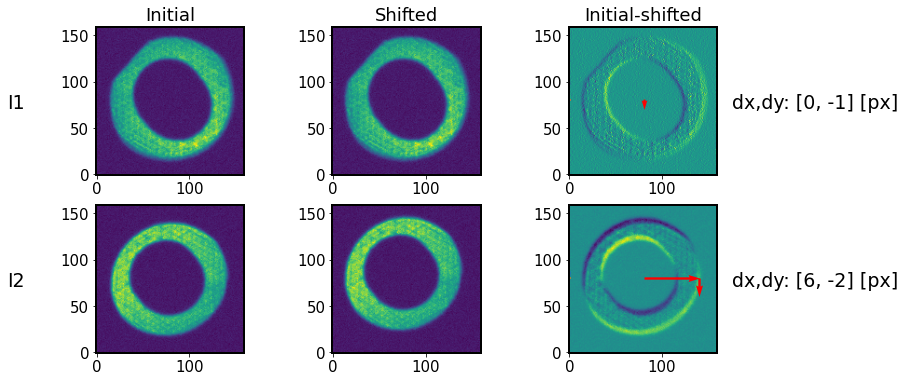

In [26]:
func.plot_imageCoCenter(algo, store, 
                      I1,I2,
                      I1imgInit,I2imgInit,
                      I1shifts, I2shifts)

The "shadow" indicates  a shift, marked by horizontal and vertical arrows (enlarged 10 times for illustration).

After the co-centering step we update the image. It is called "initial", because at each step of the outer loop the compensation is done to that image. Also initialize the computing variables `zcomp`, `zc` related to estimated Zernikes, as well as `wcomp`, `West` related to wavefront estimate:

In [27]:
# Update the self-initial image
I1.updateImgInit()
I2.updateImgInit()

# Initialize the variables used in the iteration.
algo.zcomp = np.zeros(algo.getNumOfZernikes())
algo.zc = algo.zcomp.copy()

dimOfDonut = algo._inst.dimOfDonutImg
algo.wcomp = np.zeros((dimOfDonut, dimOfDonut))
algo.West = algo.wcomp.copy()

algo.caustic = False

## Single iteration


Each iteration compensates from the original image. The `compSequence` is taken from `exp.yaml`. The `ztmp` is filled with only as many elements of `compSequence` as the iteration number.

In [28]:
# Rename this index (currentItr) for the simplification
jj = algo.currentItr

# Solve the transport of intensity equation (TIE)
if not algo.caustic:

    # Reset the images before the compensation
    I1.updateImage(I1.getImgInit().copy())
    I2.updateImage(I2.getImgInit().copy())
    
    if compMode == "zer":

        # Zk coefficient from the previous iteration
        ztmp = algo.zc.copy()

        # Do the feedback of Zk from the lower terms first based on the
        # sequence defined in compSequence
        if jj != 0:
            compSequence = algo.getCompSequence()
            print(compSequence)
            ztmp[int(compSequence[jj - 1]) :] = 0

        print(f'ztmp:{ztmp}')
        print(f'zcomp:{algo.zcomp}')
        print(f'feedbackGain:{feedbackGain}')
        print(f'ztmp*feedbackGain:{ztmp*feedbackGain}')

        # Add partial feedback of residual estimated wavefront in Zk
        algo.zcomp = algo.zcomp + ztmp * feedbackGain
        print(f'zcomp:{algo.zcomp}')

ztmp:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
zcomp:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
feedbackGain:0.6
ztmp*feedbackGain:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
zcomp:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### Image compensation (outer loop)

Now we forward the image to the pupil calling:
    
    # Remove the image distortion by forwarding the image to pupil
    I1.compensate(self._inst, self, self.zcomp, model)
    I2.compensate(self._inst, self, self.zcomp, model)
    
Steps below guide through the image compensation for the intra-focal image. Also see additional [notes on the image compensation](https://docushare.lsst.org/docushare/dsweb/Get/Document-14506/Bo_May2013.pdf).

In [29]:
# the calculated coefficients of the wavefront
zcCol = algo.zcomp


# Dimension of image
sm, sn = I1.getImg().shape

print('Image dimension:', sm, sn)

# Dimension of projected image on focal plane
projSamples = sm

# Let us create a look-up table for x -> xp first.
luty, lutx = np.mgrid[
    -(projSamples / 2 - 0.5) : (projSamples / 2 + 0.5),
    -(projSamples / 2 - 0.5) : (projSamples / 2 + 0.5),

]

Image dimension: 160 160


The look-up table is a meshgrid - a matrix representation of donut template pixel coordinates:
    
   <img src="fig01_LUT.png" alt="LUT for pixel coordinate transformation" >

In [30]:
luty

array([[-79.5, -79.5, -79.5, ..., -79.5, -79.5, -79.5],
       [-78.5, -78.5, -78.5, ..., -78.5, -78.5, -78.5],
       [-77.5, -77.5, -77.5, ..., -77.5, -77.5, -77.5],
       ...,
       [ 77.5,  77.5,  77.5, ...,  77.5,  77.5,  77.5],
       [ 78.5,  78.5,  78.5, ...,  78.5,  78.5,  78.5],
       [ 79.5,  79.5,  79.5, ...,  79.5,  79.5,  79.5]])

Then we calculate the sensor factor - the ratio of donut template size to donut size:

In [31]:
sensorFactor = algo._inst.getSensorFactor()
lutx = lutx / (projSamples / 2 / sensorFactor)
luty = luty / (projSamples / 2 / sensorFactor)

In [32]:
sensorFactor

1.3157256778309412

In [33]:
algo._inst.defocalDisOffset

0.0015

In [34]:
algo._inst.apertureDiameter

8.36

In [35]:
algo._inst.pixelSize

1e-05

In [36]:
algo._inst.dimOfDonutImg

160

<img src="fig02_donut_size.png" alt="Defocal donut size calculation." width=700>

The sensor factor is calculated as 

    sensorFactor = self.dimOfDonutImg / (
        self.defocalDisOffset * self.apertureDiameter /  self.focalLength / self.pixelSize
    )
This notation is the same as 


    dimOfDonut * [ (focalLength*pixelSize) / (offset*apertureDiameter) ] ,
     
where from the image above we have 

    d = (l*a) / f, i.e. 

    donutSizeInPixels = d / pixelSize = (offset*apertureDiameter ) / (focalLength*pixelSize)
    

with `d` being the donut size, so that indeed

    sensorFactor = dimOfDonut / donutSizeInPixels
     
     

Thus we have showed that the sensor factor indeed stands for the ratio of donut template size to donut size. 

Now we calculate the mapping from the image plane to the pupil (aperture) plane : 

<img src="fig03_Roddier1993_fig2.png" alt="Roddier+1993_Fig2" width=700 > 

Fig.2 [Roddier&Roddier+1993](https://ui.adsabs.harvard.edu/abs/1993JOSAA..10.2277R/abstract).

We consider defocused images because differences in illumination will correspond to wavefront curvature (we assume uniform or nearly uniform illumination of the pupil). As in [Roddier+1987](https://opg.optica.org/ao/fulltext.cfm?uri=ao-27-7-1223&id=165969):

> From geometrical optics considerations, it is easy to show that a local wavefront curvature will produce an excess of illumination in one plane and a lack of illumination in the other plane. The difference between the two illuminations will therefore provide a measure of the local wavefront curvature. The result should be insensitive to irradiance fluctuations in the pupil plane since they will produce a similar change of illumination in both planes and the effect will cancel out in the difference. 
<cite>François Roddier</cite>

As well as :

> Assuming the intensity is equal to I0 everywhere inside the pupil and zero outside, we have the Neumann boundary conditions 
<cite>Xin+2015</cite>

And:

> We compensate/correct the intrafocal and extrafocal images for the aberrations of the current wavefront estimate by remapping the image flux using the Jacobian of the wavefront in the pupil plane.
<cite>Xin+2015, Sec2A</cite> 

In [37]:
# Set up the mapping
lutxp, lutyp, J = I1._aperture2image(
inst, algo, zcCol, lutx, luty, projSamples, model
)

Let's investigate the `_aperture2image` function. It first sets up the transformation in reduced coordinates from image plane to pupil plane, following Xin2015 eq.(9)-(11):

<img src="fig04_reduced_coordinates.png" alt="Reduced coordinates" width=700 > 

<img src="fig05_Xin2015_eq9-11.png" alt="Xin2015_Eq9-11" width=500 > 

In the code we have 

    # Get the radius: R = D/2
    R = inst.apertureDiameter / 2

    # Calculate C = -f(f-l)/l/R^2. This is for the calculation of reduced
    # coordinate.
    defocalDisOffset = inst.defocalDisOffset
    if self.defocalType == DefocalType.Intra:
        l = defocalDisOffset
    elif self.defocalType == DefocalType.Extra:
        l = -defocalDisOffset

    focalLength = inst.focalLength
    myC = -focalLength * (focalLength - l) / l / R**2

The further transformation from the donut coordinates `lutx` , `luty` to pupil coordinates `lutxp`, `lutyp` depends on the optical model. From [AOS documentation](https://confluence.lsstcorp.org/pages/viewpage.action?pageId=56689538): 
* "paraxial" means the all incident light focuses into the focal point.
* "on-axis" allows the light from edge of lens (optical system) not to focus on the focal point. 
* "off-axis" allows the light comes in the off-axis direction, and the focal point is not (0,0) anymore. 

Ideally, the FieldXY=(0,0) in "off-axis" should give the same result as "on-axis".

<img src="fig06_optical_models.png" alt="Optical models" width=800 >    
The "on-axis" model corrects for the fast beam : 

> In a fast-beam optical system like the LSST the wavefront error defined on the reference sphere at the exit pupil can no longer be projected on the pupil plane in a straightforward, linear way. The steepness of the fast-beam reference sphere results in non- linear mapping from the pupil (x–y plane) to the intrafocal and extrafocal images (x0 –y0 plane). Consequently, the intensity distribution on the aberration-free image is no longer uniform and would give rise to anomalous wavefront aberration estimates. This effect also causes the obscuration ratio as seen at the intrafocal and extrafocal image planes to be different from that on the pupil; thus the linear equations for the mapping between x–y and x0–y0 [Eqs. (9) and (10)] are no longer valid. Therefore, we need to quantify the **nonlinear fast-beam effect**, and be able to remove it so that the corrected images can be processed using the iterative FFT or the series expansion algorithms.  <cite>Xin+2015 Sec.3B</cite>

That's why for the on-axis situation equations (9)-(11) from [Xin+2015](http://dx.doi.org/10.1364/AO.54.009045) become (22)-(24) :  


<img src="fig07_Xin2015_eq22-24.png" alt="Xin2015_Eq22-24" width=600 > 


(and for off-axis, the situation is more complex, hence was not described in the paper, but covers hundreds of lines of code).

In the end we have `lutxp`, `lutyp` set of pupil coordinates. 


The intensity is transformed using the Jacobian . Eq.13 below is from [Roddier+1993](https://opg.optica.org/josaa/fulltext.cfm?uri=josaa-10-11-2277&id=59124):

<img src="fig08_Jacobian.png" alt="Jacobian" width=600 > 




We can inspect the projection to see that for off-axis case it is far from trivial:
    
    

Text(0.5, 1.0, 'Jacobian for \noffAxis model')

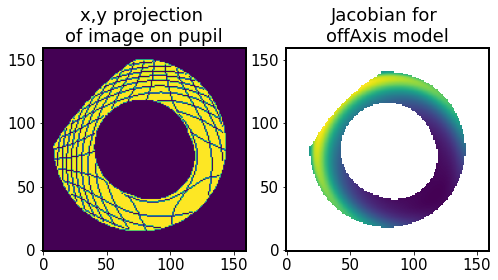

In [38]:
show_lutxyp = I1._showProjection(
            lutxp, lutyp, sensorFactor, projSamples, raytrace=False
        )

fig,ax= plt.subplots(1,2,figsize=(8,4))

ax[0].imshow(show_lutxyp, origin='lower')
ax[0].set_title('x,y projection \nof image on pupil')

ax[1].imshow(J, origin='lower')
ax[1].set_title(f'Jacobian for \n{model} model')

The following step adds a margin of 20 pixels in each dimension to make room for the morphological operations:

In [39]:
# Extend the dimension of image by 20 pixel in x and y direction
show_lutxyp_padded = padArray(show_lutxyp, projSamples + 20)


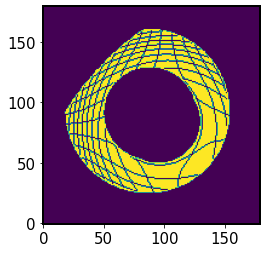

In [40]:
plt.imshow(show_lutxyp_padded, origin='lower')

This just made the stamp larger in each dimension

Now initialize the basic morphological structure:

In [41]:
# Get the binary matrix of image on pupil plane if raytrace=False
struct0 = generate_binary_structure(2, 1)
struct0

array([[False,  True, False],
       [ True,  True,  True],
       [False,  True, False]])

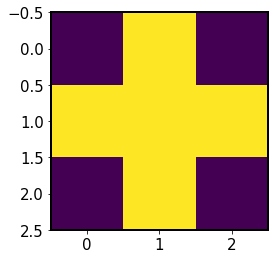

In [42]:
plt.imshow(struct0)

Dilation and erosion are two of the fundamental operations in morphological image processing (see eg. [Sapiro+1993](https://www.cs.technion.ac.il/~ron/PAPERS/morphology_1993.pdf)).

<img src="fig08a_morphological_operations.png" alt="Morphological operations" width=400 > 
The next step `iterate_structure` dilates the structure with itself. From a 3x3 array it makes an 9x9 array, effectively "smoothing" the edges:

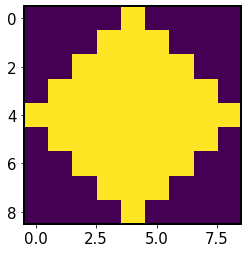

In [43]:
struct1 = iterate_structure(struct0, 4)
plt.imshow(struct1)

Next we dilate this structure with the one we started with twice:

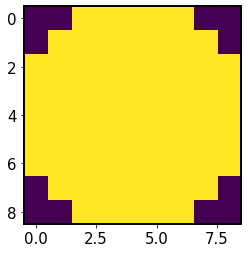

In [44]:
struct = binary_dilation(struct1, structure=struct0, iterations=2).astype(int)
plt.imshow(struct)

Now using this as a structuring element we perform binary dilation on the projection lookup table. It acts as a smoothing eraser, removing the marks of the projection grid and enlarging slightly the envelope of the LUT:

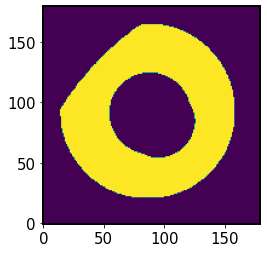

In [45]:
show_lutxyp_dilated = binary_dilation(show_lutxyp_padded, structure=struct)
plt.imshow(show_lutxyp_dilated, origin='lower')

Now this is eroded, to remove the effects of the envelope added in the process of dilation:

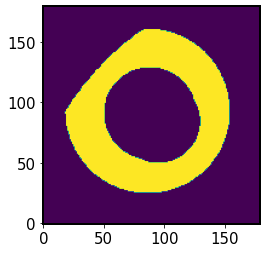

In [46]:
show_lutxyp_eroded = binary_erosion(show_lutxyp_dilated, structure=struct)
plt.imshow(show_lutxyp_eroded, origin='lower')

Next we extract the region in size equal to the original image  (160x160 px), since earlier it was padded by 20 pixels in each direction to make space for the operation of binary dilation :

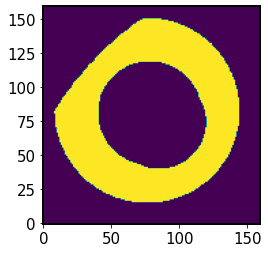

In [47]:
# Extract the region from the center of image and get the original one
show_lutxyp_extracted = extractArray(show_lutxyp_eroded, projSamples)
plt.imshow(show_lutxyp_extracted, origin='lower')

Now the re-centering step `centerOnProjections` which ensures that I1 and I2 after being shifted to the pupil plane are  aligned.

Inside `centerOnProjection` we : 

In [48]:
img = I1.getImg()
template = show_lutxyp_extracted.astype(float)
window = 20 

# Calculate the cross-correlate
corr = correlate(img, template, mode="same")


Text(0.5, 1.0, 'correlation')

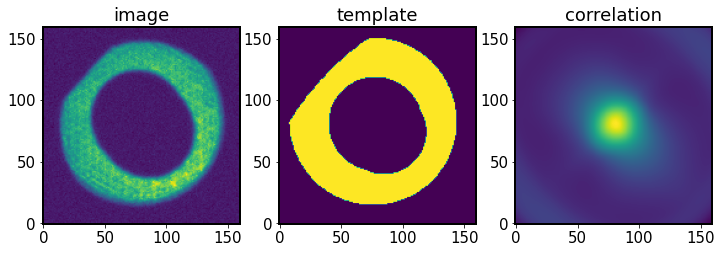

In [49]:
fig,ax = plt.subplots(1,3,figsize=(12,4))
ax[0].imshow(img, origin='lower')
ax[1].imshow(template,origin='lower')
ax[2].imshow(corr,origin='lower')
ax[0].set_title('image')
ax[1].set_title('template')
ax[2].set_title('correlation')

We only select the central region of the image convolution:

In [50]:
# Calculate the shifts of center

# Only consider the shifts in a certain window (range)
# Align the input image to the center of template
length = template.shape[0]
print(length)

center = length // 2
print(center)
r = window // 2
print(r)

160
80
10


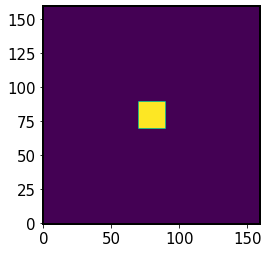

In [51]:
mask = np.zeros(corr.shape)
mask[center - r : center + r, center - r : center + r] = 1
plt.imshow(mask, origin='lower')

After convolving the template with the mask we select only the central region of the convolved image :

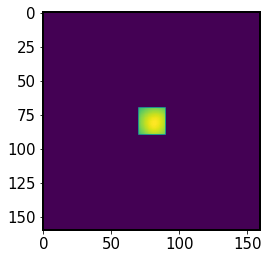

In [52]:
plt.imshow(corr*mask)

We find the location of peak pixel value in this window, and shift the image so that the peak is in the center: 

In [53]:
idx = np.argmax(corr * mask)
idx

13041

In [54]:
# The above 'idx' is an integer. Need to rematch it to the
# two-dimension position (x and y)
xmatch = idx % length
ymatch = idx // length
print(xmatch, ymatch)

81 81


In [55]:
dx = center - xmatch
dy = center - ymatch
print(dx,dy)

-1 -1


show the effect of recentering on the image:

Text(0.5, 1.0, 'recentered-original')

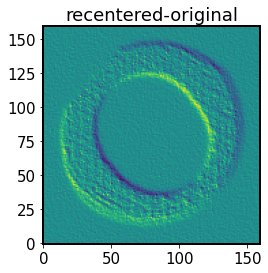

In [56]:
# Shift/ recenter the input image
imgRecenter = np.roll(np.roll(img, dx, axis=1), dy, axis=0)
plt.imshow(imgRecenter-img, origin='lower')
plt.title('recentered-original')

In [57]:
# Recenter the image
imgRecenter = I1.centerOnProjection(
    I1.getImg(), show_lutxyp.astype(float), window=20
)


In [58]:
# update the image 
I1.updateImage(imgRecenter)

# Construct the interpolant to get the intensity on (x', p') plane
# that corresponds to the grid points on (x,y)
yp, xp = np.mgrid[
    -(sm / 2 - 0.5) : (sm / 2 + 0.5), -(sm / 2 - 0.5) : (sm / 2 + 0.5)
]

xp = xp / (sm / 2 / sensorFactor)
yp = yp / (sm / 2 / sensorFactor)

# Put the NaN to be 0 for the interpolate to use
lutxp[np.isnan(lutxp)] = 0
lutyp[np.isnan(lutyp)] = 0

# Construct the function for interpolation
ip = RectBivariateSpline(yp[:, 0], xp[0, :], I1.getImg(), kx=1, ky=1)

# Construct the projected image by the interpolation
lutIp = ip(lutyp, lutxp, grid=False)


Thus we have constructed an interpolated image (that accounts for coordinate transformation), which together with the Jacobian (adjusting the intensity by applying flux conservation) provides an image interpolated to the pupil plane:

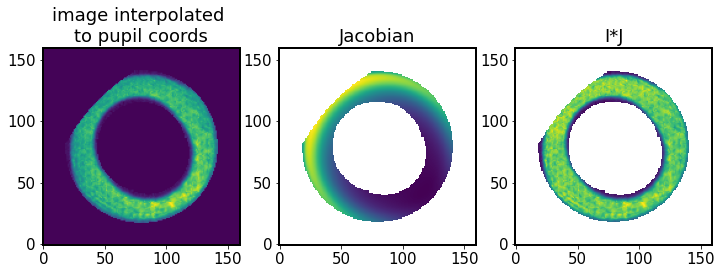

In [59]:
# image interpolated to pupil plane 
fig,ax = plt.subplots(1,3,figsize=(12,4))

ax[0].set_title('image interpolated \nto pupil coords')
ax[0].imshow(lutIp, origin='lower')


ax[1].set_title('Jacobian')
ax[1].imshow(J, origin='lower')

ax[2].set_title('I*J')
ax[2].imshow(lutIp * J, origin='lower')

### apply common mask

At this point, we're back in `Algorithm`,  single iteration. We can call all the above steps as a single command:

In [60]:
# undo the changes done in the above explanation for I1
I1.updateImage(I1.getImgInit())

# perform image compensation for intra- and extra-focal images 
if not algo.caustic:
    if compMode == "zer":
        # Remove the image distortion by forwarding the image to pupil
        I1.compensate(algo._inst, algo, algo.zcomp, model)
        I2.compensate(algo._inst, algo, algo.zcomp, model)

In [61]:
# Check the image condition. If there is the problem, done with
# this _singleItr().
if (I1.isCaustic() is True) or (I2.isCaustic() is True):
    algo.converge[:, jj] = algo.converge[:, jj - 1]
    algo.caustic = True
    #return

Now we apply the common pupil mask. This is as in Section 3D: 
    
> To avoid anomalous signal due to the difference in vignetting from entering the wavefront estimation results, we mask off the intrafocal and extrafocal images using a common pupil mask, which is the logical AND of the pupil masks at the intrafocal and extrafocal field positions. <cite>Xin2015, Sec 3D</cite>

Inside `_applyI1I2mask_pupil` : 

 

In [62]:
# Get the overlap region of images and do the normalization.
if I1.getFieldXY() != I2.getFieldXY():

    # Get the overlap region of image
    I1_overlap = I1.getImg() * algo.mask_pupil

    # Rotate mask_pupil by 180 degree through rotating two times of 90
    # degree because I2 has been rotated by 180 degree already.
    I2_rotated = I2.getImg() * np.rot90(algo.mask_pupil, 2)
    
    # Do the normalization of image.
    I1_norm = I1_overlap / np.sum(I1_overlap)
    I2_norm = I2_rotated / np.sum(I2_rotated)

Text(0.5, 1.0, 'normalized')

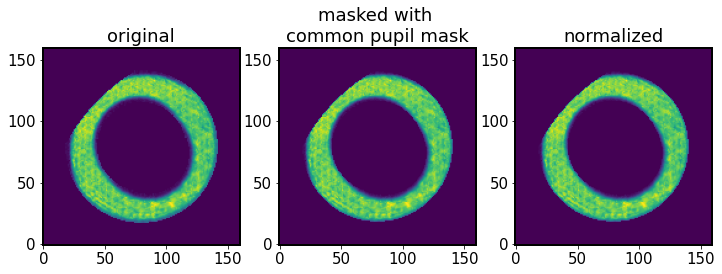

In [63]:
fig,ax = plt.subplots(1,3,figsize=(12,4))
ax[0].imshow(I1.getImg(), origin='lower')
ax[1].imshow(I1_overlap, origin='lower')
ax[2].imshow(I1_norm, origin='lower')
ax[0].set_title('original')
ax[1].set_title('masked with \ncommon pupil mask')
ax[2].set_title('normalized')

Same as above, but for the extra-focal donut (multiplied by the rotated mask):

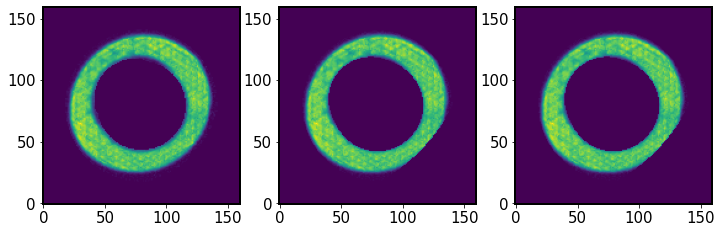

In [64]:
fig,ax = plt.subplots(1,3,figsize=(12,4))
ax[0].imshow(I2.getImg(), origin='lower')
ax[1].imshow(I2_rotated, origin='lower')
ax[2].imshow(I2_norm, origin='lower')

In [65]:
# Correct the defocal images if I1 and I2 are belong to different
# sources, which is determined by the (fieldX, field Y)
I1, I2 = algo._applyI1I2mask_pupil(I1, I2)

### Solve Poisson's equation (inner loop) 
    

It is called via 
    
    # Solve the Poisson's equation
    self.zc, self.West = self._solvePoissonEq(I1, I2, jj)
    
First we find an infinitesimal volume element $\mathrm{d} \Omega$ used in eq.17 below (adapted from [Xin+2015](http://dx.doi.org/10.1364/AO.54.009045)):

In [66]:
# Calculate the aperture pixel size
apertureDiameter = algo._inst.apertureDiameter
sensorFactor = algo._inst.getSensorFactor()
dimOfDonut = algo._inst.dimOfDonutImg
aperturePixelSize = apertureDiameter * sensorFactor / dimOfDonut

# Calculate the differential Omega
dOmega = aperturePixelSize**2

# Solve the Poisson's equation based on the type of algorithm
numTerms = algo.getNumOfZernikes()
zobsR = algo.getObsOfZernikes()
PoissonSolver = algo.getPoissonSolverName()

The sensor factor (ratio of donut postage stamp image size to donut size) is the same as calculated above during the image compensation. We quickly prove that `sensorFactor` is indeed just a ratio of donut template size in px to donut size in px :

In [67]:
offset = algo._inst.defocalDisOffset
apertureDiameter = algo._inst.apertureDiameter
focalLength = algo._inst.focalLength
pixelSize = algo._inst.pixelSize

donutSize =  (offset*apertureDiameter) / (focalLength*pixelSize)
donutSize

121.60589604344452

In [68]:
dimOfDonut/ donutSize

1.3157256778309412

In [69]:
sensorFactor

1.3157256778309412

Next we calculate I0 and dI - the image sum (to approximate the mean intensity) and the difference (to approximate the change in intensity across $\partial z$), as in Eq.(3) in [Xin+2015](http://dx.doi.org/10.1364/AO.54.009045). 

In [70]:
# Calculate I0 and dI
I0, dI = algo._getdIandI(I1, I2)

Text(0.5, 1.0, 'difference image')

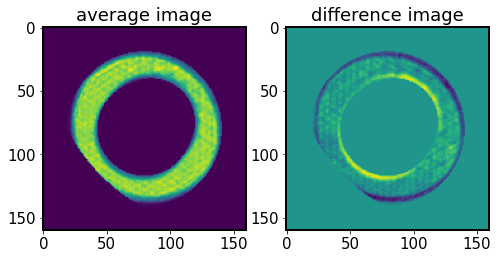

In [71]:
fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].imshow(I0)
ax[0].set_title('average image')

ax[1].imshow(dI)
ax[1].set_title('difference image')

This step calculates the sensor coordinates. These are pixel coordinates scaled by the donut radius, i.e. they are in terms of multiples of donut radii:

    ySensorGrid, xSensorGrid = np.mgrid[
            -(self.dimOfDonutImg / 2 - 0.5) : (self.dimOfDonutImg / 2 + 0.5),
            -(self.dimOfDonutImg / 2 - 0.5) : (self.dimOfDonutImg / 2 + 0.5),
        ]
    
    #i.e. xSensorGrid = [-79.5,.....79.5] as before , since donut template is 160 px across
    
    sensorFactor = self.getSensorFactor()  = ( template size ) /  ( donut size )
   
    denominator = self.dimOfDonutImg / 2 / sensorFactor = (donut radius)
 
 
    self.xSensor = xSensorGrid / denominator
    
    # i.e. xSensor = [-1.30750239 -1.29105582 ... 1.29105582 , 1.30750239]

In [72]:
xSensor, ySensor = algo._inst.getSensorCoor()

We multiply these coordinates by the computational mask. This limits the array to the extent of the mask:   

In [73]:
xSensor = xSensor * algo.mask_comp
ySensor = ySensor * algo.mask_comp

In the following we obtain Zernikes and Zernike x- and y- gradients. They come from `galsim.zernike.zernikeBasis`:

In [74]:
# Get Zernike and gradient bases from cache.  These are each
# (nzk, npix, npix) arrays, with the first dimension indicating
# the Noll index.
zk, dzkdx, dzkdy = algo._zernikeBasisCache()

The `zk` array contains 22 sub-arrays (equal to the number of fitted Zernike coefficients), each 160x160 px in size (equal to the size of postage stamp images):

In [75]:
zk.shape

(22, 160, 160)

Show a single Zk, and its dx, dy gradients:

Text(0.5, 1.0, 'd(zk3)/dy')

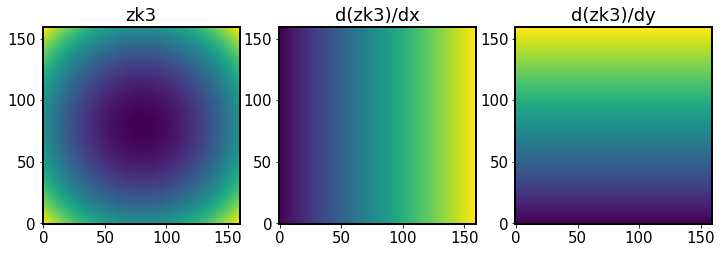

In [76]:
fig,ax = plt.subplots(1,3,figsize=(12,4))
N=3
ax[0].imshow(zk[N,], origin='lower')
ax[0].set_title(f'zk{N}')

ax[1].imshow(dzkdx[N,],origin='lower')
ax[1].set_title(f'd(zk{N})/dx')

ax[2].imshow(dzkdy[N,],origin='lower')
ax[2].set_title(f'd(zk{N})/dy')

Now we proceed to solve the Transport of Intensity Equation (TIE) via series expansion. From [Xin+2015](http://dx.doi.org/10.1364/AO.54.009045), Sec2B:
   
 <img src="fig09_Xin2015_eq13-15.png" alt="Xin2015_Eq13-15" width=500 > 
 <img src="fig10_Xin2015_eq16-17.png" alt="Xin2015_Eq16-17" width=600 > 
 <img src="fig11_Xin2015_eq18-21.png" alt="Xin2015_Eq18-21" width=600 > 

   

In [77]:
# Eqn. (19) from Xin et al., Appl. Opt. 54, 9045-9054 (2015).
# F_j = \int (d_z I) Z_j d_Omega
F = np.tensordot(dI, zk, axes=((0, 1), (1, 2))) * dOmega

[ Note : this is not exactly eq.19, because instead of calculating 
    
   $F = \int\int (\partial I / \partial z) Z_{j} d\Omega $  

we've only got here    
   
   $\int\int \partial I  Z_{j} d\Omega$
   
that is why we need to divide later by $\partial z$ (approximated by $\Delta z$, i.e. $f(f-l)/l$, eq.5 in [Xin+2015](http://dx.doi.org/10.1364/AO.54.009045)) ] 

In [78]:
# Eqn. (20) from Xin et al., Appl. Opt. 54, 9045-9054 (2015).
# M_ij = \int I (grad Z_j) . (grad Z_i) d_Omega
#      =   \int I (dZ_i/dx) (dZ_j/dx) d_Omega
#        + \int I (dZ_i/dy) (dZ_j/dy) d_Omega
Mij = np.einsum("ab,iab,jab->ij", I0, dzkdx, dzkdx)
Mij += np.einsum("ab,iab,jab->ij", I0, dzkdy, dzkdy)
Mij *= dOmega / (apertureDiameter / 2.0) ** 2

In [79]:
# Calculate dz
focalLength = algo._inst.focalLength
offset = algo._inst.defocalDisOffset
dz = 2 * focalLength * (focalLength - offset) / offset

# Define zc
zc = np.zeros(numTerms)

# Consider specific Zk terms only
idx = algo.getZernikeTerms()

In [80]:
focalLength

10.312

In [81]:
offset

0.0015

Solve $W= M^{-1} F$, dividing $F$ by $\partial z$ to close eq.(19) (above we only calculated $dI Z d\Omega$ rather than $(\partial I / \partial z )Z d\Omega$):

In [82]:
# Solve the equation: M*W = F => W = M^(-1)*F
zc_tmp = np.linalg.lstsq(Mij[:, idx][idx], F[idx], rcond=None)[0] / dz
zc[idx] = zc_tmp

Illustrate the initial estimated wavefront:

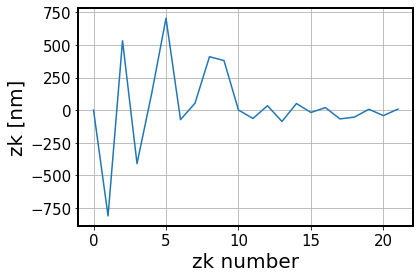

In [83]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(zc_tmp*1e9)
ax.set_xlabel('zk number')
ax.set_ylabel('zk [nm]')
ax.grid()

In [84]:
from lsst.ts.wep.cwfs.Tool import ZernikeAnnularEval 

# Estimate the wavefront surface based on z4 - z22
# z0 - z3 are set to be 0 instead
West = ZernikeAnnularEval(
    np.concatenate(([0, 0, 0], zc[3:])), xSensor, ySensor, zobsR
)

Illustrate the estimated wavefront, used for image compensation in the next step of the outer loop:

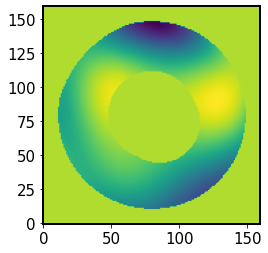

In [85]:
plt.imshow(West, origin='lower')

In [86]:
# pass the result of solving Poisson equation to algo
algo.zc = zc
algo.West = West

In [87]:
# zks from current iteration
algo.zc

array([ 0.00000000e+00, -8.11662860e-07,  5.32176247e-07, -4.09957070e-07,
        1.21267249e-07,  7.05065498e-07, -7.26892248e-08,  5.29453797e-08,
        4.09984803e-07,  3.80384617e-07,  6.68396160e-10, -6.39617286e-08,
        3.39015348e-08, -8.68395109e-08,  5.07315248e-08, -1.78579284e-08,
        1.94569699e-08, -6.74214192e-08, -5.34282465e-08,  6.63418581e-09,
       -4.21152277e-08,  7.92490377e-09])

In [88]:
from lsst.ts.wep.cwfs.Tool import (
    padArray,
    extractArray,
    ZernikeAnnularEval,
    ZernikeMaskedFit)

# Record/ calculate the Zk coefficient and wavefront
if compMode == "zer":
    algo.converge[:, jj] = algo.zcomp + algo.zc

    xoSensor, yoSensor = algo._inst.getSensorCoorAnnular()

The `getSensorCoorAnnular` function finds the sensor coordinates masking out the positions outside the annular aperture range

In [89]:
#setSensorCoorAnnular:

# Get the position index that is out of annular aperature range
obscuration = algo._inst.obscuration
r2Sensor = algo._inst.xSensor**2 + algo._inst.ySensor**2



Initially `r2Sensor` is the radial coordinate, $r=x^2+y^2$

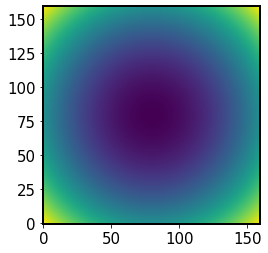

In [90]:
plt.imshow(r2Sensor, origin='lower')

We mask region outside the aperture radius, and below the obscuration radius:

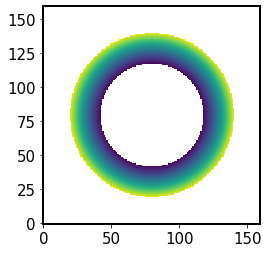

In [91]:
idx = (r2Sensor > 1) | (r2Sensor < obscuration**2)
r2Sensor[idx] = np.nan
plt.imshow(r2Sensor, origin='lower')

This is used to evaluate the calculated wavefront:

In [92]:
if compMode == "zer":
    wavefront_previous_estimate = ZernikeAnnularEval(
        np.concatenate(([0, 0, 0], algo.zcomp[3:])),
        xoSensor,
        yoSensor,
        algo.getObsOfZernikes(),
    )

    algo.wcomp = algo.West + wavefront_previous_estimate

Finally, the information about converged Zernike coefficients in $j-th$ iteration of the outer loop is stored as $Z_{j}$. It is compared with the values from previous iteration $Z_{j-1}$. If $\sum |Z_{j} - Z_{j-1}|$ is smaller than the tolerance level, the calculation is assumed to have converged. 

In [93]:
if algo.caustic:
    # Once we run into caustic, stop here, results may be close to real
    # aberration.
    # Continuation may lead to disastrous results.
    algo.converge[:, jj] = algo.converge[:, jj - 1]

# Record the coefficients of normal/ annular Zernike polynomials after
# z4 in unit of nm
algo.zer4UpNm = algo.converge[3:, jj] * 1e9

# Status of iteration
stopItr = False

# Calculate the difference
if jj > 0:
    diffZk = (
        np.sum(np.abs(algo.converge[:, jj] - algo.converge[:, jj - 1])) * 1e9
    )

    # Check the Status of iteration
    if diffZk < tol:
        stopItr = True

# Update the current iteration time
algo.currentItr += 1

# Show the Zk coefficients in interger in each iteration
if algo.debugLevel >= 2:
    print("itr = %d, z4-z%d" % (jj, algo.getNumOfZernikes()))
    print(np.rint(algo.zer4UpNm))


## Multiple iterations

In the following we run multiple iterations of the outer loop, and show how the intermediate data products change:

In [94]:
imp.reload(func)
mag = 15
repo_dir = f'/sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_{mag}/phosimData/'
instrument = 'LSSTCam'
collection = 'ts_phosim_9006000'
sensor='R04'
donutStampsExtra, extraFocalCatalog = func.get_butler_stamps(repo_dir,instrument=instrument, 
                                      iterN=0, detector=f"{sensor}_SW0",
                                      dataset_type = 'donutStampsExtra', 
                                      collection=collection)

donutStampsIntra, intraFocalCatalog = func.get_butler_stamps(repo_dir,instrument=instrument, 
                                      iterN=0, detector=f"{sensor}_SW1",
                                      dataset_type = 'donutStampsIntra', 
                                      collection=collection)

extraImage = func.get_butler_image(repo_dir,instrument=instrument,
                              iterN=0, detector=f"{sensor}_SW0",
                              collection=collection)


                              # get the pixel scale from exposure to convert from pixels to arcsec to degrees
pixelScale = extraImage.getWcs().getPixelScale().asArcseconds()
configDir = getConfigDir()
instDir = os.path.join(configDir, "cwfs", "instData")
algoDir = os.path.join(configDir, "cwfs", "algo")

# inside wfEsti = WfEstimator(instDir, algoDir)

# this is part of the init
inst = Instrument()
algo = Algorithm(algoDir)

# inside estimateZernikes()
instName='lsst'
camType = getCamType(instName)
defocalDisInMm = getDefocalDisInMm(instName)

# inside wfEsti.config
opticalModel = 'offAxis'
sizeInPix = 160  # aka donutStamps
inst.configFromFile(sizeInPix, camType)
# choose the solver for the algorithm
solver = 'exp' # by default
debugLevel = 0 # 1 to 3
algo.config(solver, inst, debugLevel=debugLevel)

centroidFindType = CentroidFindType.RandomWalk
imgIntra = CompensableImage(centroidFindType=centroidFindType)
imgExtra = CompensableImage(centroidFindType=centroidFindType)

# select a donut pair in that corner
i=1
donutExtra = donutStampsExtra[i]
j=4
donutIntra = donutStampsIntra[j]


# Inside EstimateZernikesBase
# Transpose field XY because CompensableImages below are transposed
# so this gets the correct mask orientation in Algorithm.py
fieldXYExtra = donutExtra.calcFieldXY()[::-1]
fieldXYIntra = donutIntra.calcFieldXY()[::-1]

# same camera for both donuts
camera = donutExtra.getCamera() 
detectorExtra = camera.get(donutExtra.detector_name)
detectorIntra = camera.get(donutIntra.detector_name)


# Rotate any sensors that are not lined up with the focal plane.
# Mostly just for the corner wavefront sensors. The negative sign
# creates the correct rotation based upon closed loop tests
# with R04 and R40 corner sensors.
eulerZExtra = -detectorExtra.getOrientation().getYaw().asDegrees()
eulerZIntra = -detectorIntra.getOrientation().getYaw().asDegrees()

# now inside  `wfEsti.setImg` method,
# which inherits from `CompensableImage`
imgExtra.setImg(fieldXYExtra,
                DefocalType.Extra,
                image=rotate(donutExtra.stamp_im.getImage().getArray(), eulerZExtra).T)

imgIntra.setImg(fieldXYIntra,
                DefocalType.Intra,
                image=rotate(donutIntra.stamp_im.getImage().getArray(), eulerZIntra).T)


# rename to just like it is in Algorithm.py
algo, store = func.runIt_store(algo, imgIntra, imgExtra, model=opticalModel, 
                      tol=1e-3)

fname = f'DM-35922_store_extra-{i}_intra-{j}.npy'
fpath = os.path.join('DM-35922',fname)
print(fpath)
np.save(fpath, store, )

DM-35922/DM-35922_store_extra-1_intra-4.npy


Illustrate the results. First plot the values of Zernikes from each iteration to show the algorithm progression:

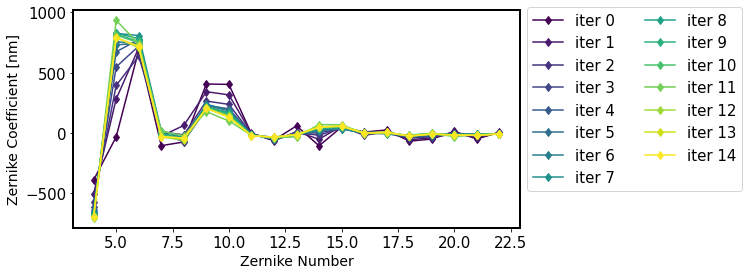

In [95]:
store = np.load(fpath, allow_pickle=True).item()
fig,ax = plt.subplots(1,1,figsize=(8,4))

nlines = len(store.keys())
color_idx = np.linspace(0, 1, nlines)
ax_legend_handles = []
cmap = plt.cm.viridis

for jj in store.keys():
    color = cmap(color_idx[jj])
    plt.plot(np.arange(4, 23),store[jj]['zer4UpNm'], '-d', label=f'iter {jj}',
            color=color)
    line = mlines.Line2D([], [], color=color, ls='-', marker='o', alpha=1,
                                 )
    ax_legend_handles.append(f'iter {jj} ')
    
plt.xlabel('Zernike Number', size=14)
plt.ylabel('Zernike Coefficient [nm]', size=14)
plt.legend( bbox_to_anchor=[1, 1.05], ncol=2)

intra 0
extra 1


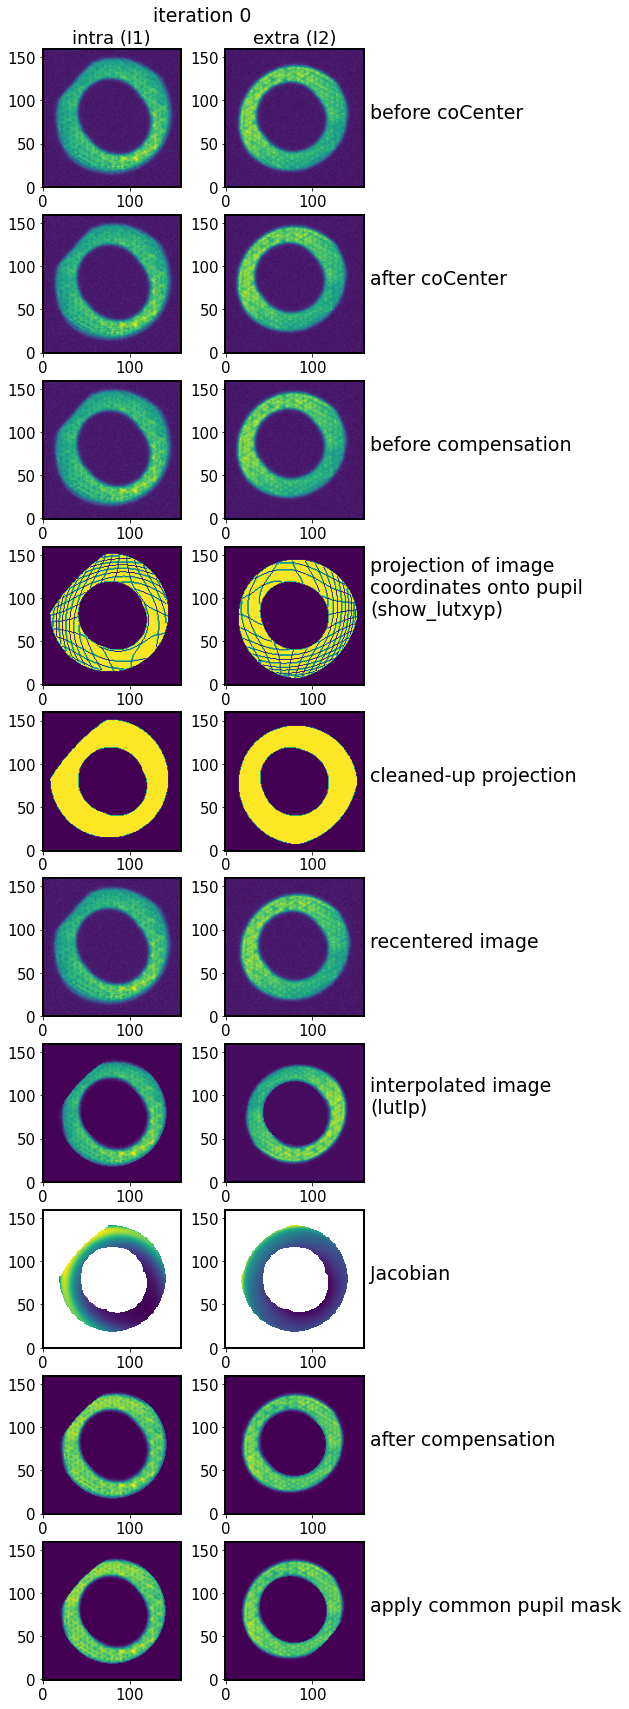

In [96]:
func.plot_algo_steps(store, iterNum=0)

Thus each individual data product can be accessed and compared between individual iterations.